##Dowmload the dataset
首先先下載本次作業所需要用到的資料，解壓縮後資料夾內的結構如下
```
data/
|----train_50
    |----0_0.png
    |----0_1.png
    ...
|----val_50
    |----0_450.png
    |----0_451.png
    ...
|----val_gt.csv
```
資料集是Imagenet的一小部分，是很多模型用來測試其效果的資料集，原本Imagenet有1000個分類，但這次作業只會取其中50個類別來分類，另外這次作業分為train_set和validation_set，同學需要透過train_set訓練模型，再來透過validation_set驗證圖片的第一個數字代表他所屬的class

**注意!!!
在做模型的訓練時只可以用train_set的資料，不可以用到validation_set的資料，被發現的話以零分處理**


In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jun 23 05:06:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!gdown --id 1JI_LGAJADDOPfEPeOW7_3NiBYMvJ6n4J --output "data.zip"
!unzip -q "data.zip"

Downloading...
From: https://drive.google.com/uc?id=1JI_LGAJADDOPfEPeOW7_3NiBYMvJ6n4J
To: /content/data.zip
66.3MB [00:00, 128MB/s] 


##Mount Google Drive(Optional)
由於Colab會有長期沒有使用的話自動斷線的可能性，因此可以掛載google雲端硬碟，並週期性的將模型儲存在雲端硬碟中


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install transformers==4.5.0

     |████████████████████████████████| 2.2MB 4.1MB/s 
     |████████████████████████████████| 901kB 28.2MB/s 
     |████████████████████████████████| 3.3MB 37.6MB/s 


##Import the package

In [5]:
import os
import glob

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from transformers import get_linear_schedule_with_warmup

由於訓練過程中會有一些隨機性，為了確保每次重新訓練的情況下都可以得到同樣的結果，因此將random、torch、numpy三個套件的 random seed固定

In [6]:
import random

import torch
import numpy as np


def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(0)

##Dataset
TODO

可以參考之前提供的sample code 完成客製化的Dataset class

In [7]:
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((224, 224)),
    # transforms.RandomVerticalFlip(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
])

valid_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
])

In [8]:
from PIL import Image
from os import listdir,walk
from os.path import join

class IMAGE(Dataset):
  def __init__(self,root,transform=None):
    self.transform = transform
    self.filenames = []
    files = sorted(glob.glob(os.path.join(root, '*.png')), key = lambda x:(int(x.split('/')[-1].split('_')[0]), int(x.split('_')[-1].split('.')[0])))
    # files = glob.glob(os.path.join(root, '*.png'))
    # files = listdir(root)
    for fn in files:
      head = fn.split('/')[4]
      head = head.split('_')[0]
      head = int(head)
      self.filenames.append((fn, head))
    self.len = len(self.filenames)

  def __getitem__(self,index):
    image_fn,label = self.filenames[index]
    image = Image.open(image_fn)
    if self.transform is not None:
      image = self.transform(image)
    return image,label

  def __len__(self):
    return self.len

In [9]:
train_set = IMAGE(root = '/content/data/train_50',transform = train_tfm)
valid_set = IMAGE(root = '/content/data/val_50',transform = valid_tfm)

a,b = valid_set[68]
print(b)

print(len(train_set))
print(len(valid_set))

1
22500
2500


In [10]:
batch_size = 128

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
a,b = valid_set[0]
print(a.shape)
print(b)

torch.Size([3, 224, 224])
0


In [12]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


##MODEL
這次的作業不會一定要同學重頭開始訓練，pytorch有內建在不同種資料集訓練的模型，有各種不同的方式可以載入預訓練好的模型，以下提供一個方法給同學，但需要注意的是同學最好還是要了解一下使用的模型架構，像是以Imagenet訓練的模型最後會輸出1000個值，但是這次的小資料集只需要分成50個類別，因此可能就需要做一些調整
```
import torchvision.models as models 
model = models.vgg16(pretrained=True)
```

In [13]:
import torchvision.models as models

class Net(nn.Module):
    def __init__(self):
      # TODO
      super(Net, self).__init__()

      self.load_model = models.resnet34(pretrained = True)
      self.Layer = nn.Linear(1000, 50)
      # self.resnet18.fc.out_features = 50

    def forward(self, x):
      # TODO 
      x = self.load_model(x)
      x = self.Layer(x)
      return x


In [14]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = Net().to(device)

# model.device = device
print(model)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth



Net(
  (load_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [15]:
!cp -r /content/drive/MyDrive/checkpoint/ /content/

##Training function

In [16]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'state_dict': model.state_dict(),
             'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

def train_save(model, epoch, save_interval, log_interval=100):
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    model.train()

    max_steps = len(train_loader) / batch_size
    scheduler = get_linear_schedule_with_warmup(optimizer, 15, max_steps)
    
    iteration = 0
    for ep in range(epoch):
        if ep%5 == 0:
          scheduler.step()
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} Lr: {}'.format(
                    ep, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item(), optimizer.param_groups[0]['lr']))
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('/content/checkpoint/model%i.pth' % iteration, model, optimizer)
            iteration += 1
        validate(model)
    save_checkpoint('/content/checkpoint/model%i.pth' % iteration, model, optimizer)

def validate(model):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(valid_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))

In [ ]:
# def train(model, epoch, log_interval=100):
#     optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)
#     criterion = nn.CrossEntropyLoss()
#     load_checkpoint('/content/checkpoint/model.ckpt', model, optimizer)
#     model.train()  # Important: set training mode

#     max_steps = len(train_loader) / batch_size
#     scheduler = get_linear_schedule_with_warmup(optimizer, 5, max_steps)
    
#     iteration = 0
#     for ep in range(epoch):
#         best_model_acc = 0
#         scheduler.step()
#         for batch_idx, (data, target) in enumerate(train_loader):
#             data, target = data.to(device), target.to(device)
#             optimizer.zero_grad()
#             output = model(data)
#             loss = criterion(output, target)
#             loss.backward()
#             optimizer.step()

#             if iteration % log_interval == 0:
#                 print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} Lr: {}'.format(
#                     ep, batch_idx * len(data), len(train_loader.dataset),
#                     100. * batch_idx / len(train_loader), loss.item(), optimizer.param_groups[0]['lr']))
#             iteration += 1
        
#         save_checkpoint('/content/checkpoint/model.ckpt', model, optimizer)
#         test(model) # Evaluate at the end of each epoch

# def test(model):
#     criterion = nn.CrossEntropyLoss()
#     model.eval()  # Important: set evaluation mode
#     test_loss = 0
#     correct = 0
#     with torch.no_grad(): # This will free the GPU memory used for back-prop
#         for data, target in valid_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             test_loss += criterion(output, target).item()*len(data) # sum up batch loss
#             pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
#             correct += pred.eq(target.view_as(pred)).sum().item()

#     test_loss /= len(valid_loader.dataset)
#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(valid_loader.dataset),
#         100. * correct / len(valid_loader.dataset)))

In [ ]:
train_save(model, 35, 1000)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

Train Epoch: 0 [0/22500 (0%)]	Loss: 4.094371 Lr: 6.666666666666667e-06
Train Epoch: 0 [12800/22500 (57%)]	Loss: 2.691191 Lr: 6.666666666666667e-06

Test set: Average loss: 0.0165, Accuracy: 1205/2500 (48%)

Train Epoch: 1 [3072/22500 (14%)]	Loss: 1.809620 Lr: 6.666666666666667e-06
Train Epoch: 1 [15872/22500 (70%)]	Loss: 1.546705 Lr: 6.666666666666667e-06

Test set: Average loss: 0.0105, Accuracy: 1626/2500 (65%)

Train Epoch: 2 [6144/22500 (27%)]	Loss: 1.005248 Lr: 6.666666666666667e-06
Train Epoch: 2 [18944/22500 (84%)]	Loss: 0.896064 Lr: 6.666666666666667e-06

Test set: Average loss: 0.0081, Accuracy: 1794/2500 (72%)

Train Epoch: 3 [9216/22500 (41%)]	Loss: 0.850237 Lr: 6.666666666666667e-06
Train Epoch: 3 [22016/22500 (98%)]	Loss: 0.713460 Lr: 6.666666666666667e-06

Test set: Average loss: 0.0069, Accuracy: 1874/2500 (75%)

Train Epoch: 4 [12288/22500 (55%)]	Loss: 0.696665 Lr: 6.666666666666667e-06

Test set: Average loss: 0.0062, Accuracy: 1926/2500 (77%)

Train Epoch: 5 [2560/225

# **Validation**

In [17]:
state = torch.load('/content/checkpoint/model6160.pth')
model.load_state_dict(state['state_dict'])
# optimizer.load_state_dict(state['optimizer'])

<All keys matched successfully>

In [18]:
def validate(model, result):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.max(1, keepdim=True)[1]
            for k in pred:
              result.append(int(k.cpu()))
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(valid_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))
    return result

In [19]:
Y = []
Y = validate(model,Y)
print(len(Y))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Test set: Average loss: 0.0055, Accuracy: 2099/2500 (84%)

2500


In [ ]:
import csv

with open('/content/data/val_gt.csv', newline='') as csvfile:

    # 讀取 CSV 檔案內容
    rows = csv.reader(csvfile)
    Rows = list(rows)
    data_names = []
    for i in range(1,len(Rows)):
      data_names.append(Rows[i][0])
    # print(datas)

with open('output.csv', 'w') as f:
    f.write('image_id,label\n')
    for i, ele in enumerate(Y):
        f.write('{},{}\n'.format(data_names[i],Y[i]))

In [ ]:
!cp -r /content/checkpoint_2/ /content/drive/MyDrive/

# **Visualization**

Reference: https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [20]:
modules = list(model.children())[:-1]
new_model = nn.Sequential(*modules)

predict = []
label = []
new_model.eval()
with torch.no_grad():
  for data, target in valid_loader:
    data, target = data.cuda(), target.cuda()
    output = new_model(data)
    predict.append(output)
    label.append(target.cpu())

print(predict[0].shape)
print(len(label))

for i,element in enumerate(predict):
  if i==0:
    x = element.cpu()
  else:
    x = np.concatenate((x,element.cpu()),axis = 0)
for j,element in enumerate(label):
  if j==0:
    y = element.cpu()
  else:
    y = np.concatenate((y,element.cpu()),axis = 0)
print(x.shape)
print(y.shape)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1000])
20
(2500, 1000)
(2500,)


In [ ]:
# import csv

# with open('/content/data/val_gt.csv', newline='') as csvfile:

#     # 讀取 CSV 檔案內容
#     rows = csv.reader(csvfile)
#     Rows = list(rows)
#     data_names = []
#     for i in range(1,len(Rows)):
#       data_names.append(Rows[i][0])
#     # print(datas)

In [ ]:
# with open('output.csv', 'w') as f:
#     f.write('image_id,label\n')
#     for i, ele in enumerate(y):
#         f.write('{},{}\n'.format(data_names[i],y[i]))

In [ ]:
!cp -p /content/output.csv/ /content/checkpoint/

cp: cannot stat '/content/output.csv/': Not a directory


In [ ]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
# from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [ ]:
feat_cols = [ 'pixel'+str(i) for i in range(x.shape[1]) ]
df = pd.DataFrame(x,columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))
# X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (2500, 1002)


In [ ]:
# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

## **PCA**

In [ ]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
# df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.14299476 0.11927173 0.06398981]


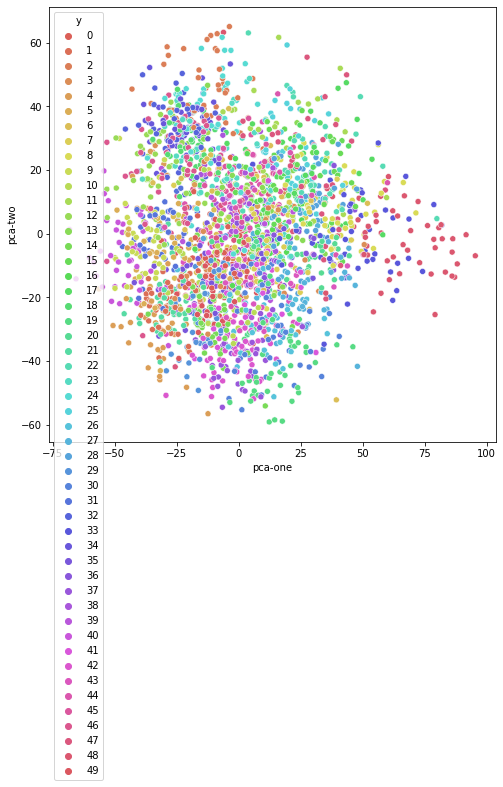

In [ ]:
plt.figure(figsize=(8,8))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 50),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=1.0
)

In [ ]:
N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.14299482 0.11927173 0.06398989]


# **T-SNE**

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.222s...
[t-SNE] Computed neighbors for 2500 samples in 12.214s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 16.519244
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.427597
[t-SNE] KL divergence after 300 iterations: 1.032875
t-SNE done! Time elapsed: 19.178000450134277 seconds


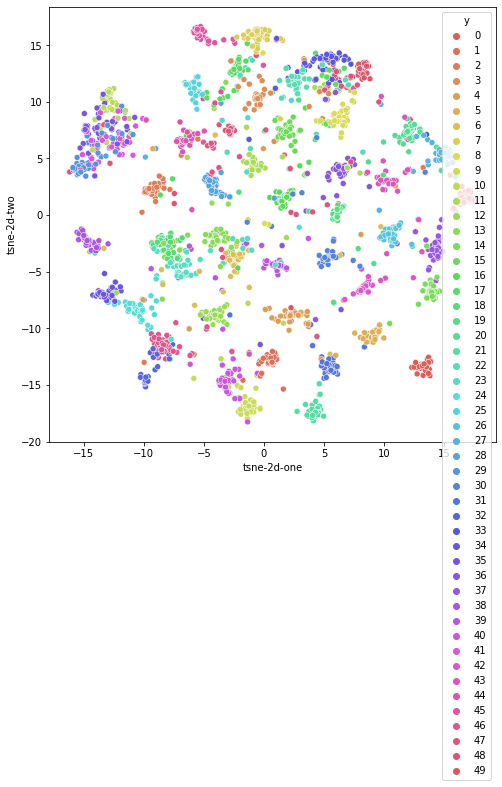

In [ ]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(8,8))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 50),
    data=df_subset,
    legend="full",
    alpha=1.0
)

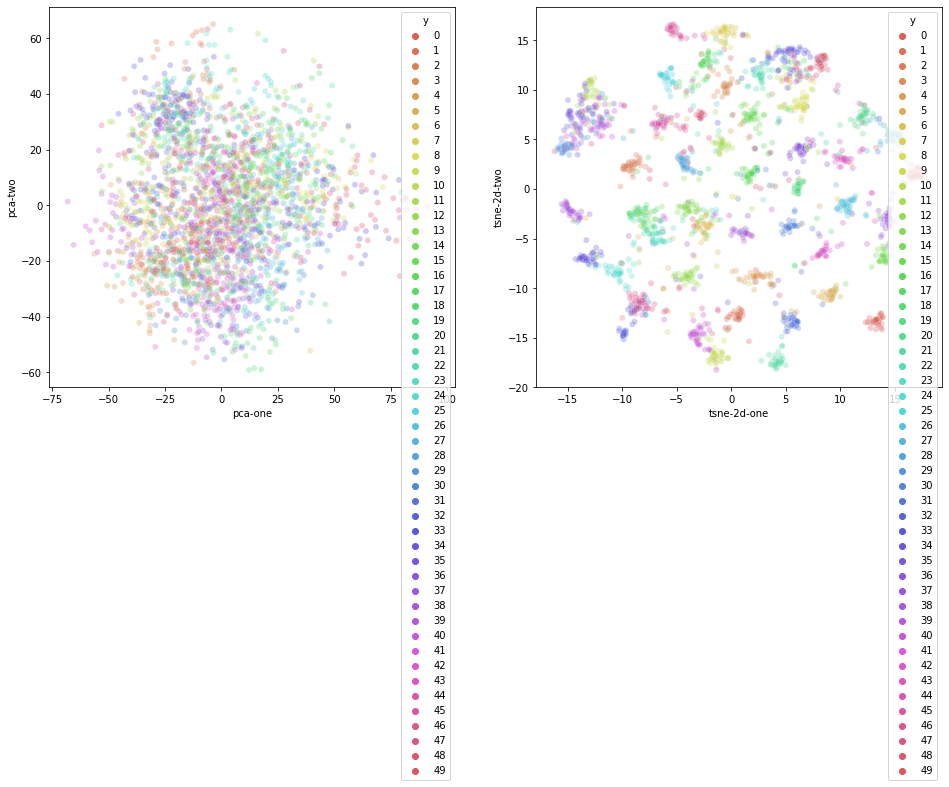

In [ ]:
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 50),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 50),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)